This notebook peforms training and scoring of boosted decision tree models for the retail sales forecasting benchmark OrangeJuice_Pt_3Weeks_Weekly. It trains the model using [LightGBM Python package](https://github.com/Microsoft/LightGBM) from Microsoft, which is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms. In addition, it visualizes the feature importance and forecast results. 

In [1]:
import os
import sys
import math
import itertools
import datetime
import random
import numpy as np
import pandas as pd
import lightgbm as lgb 
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from common.evaluation_utils import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [3]:
# Data paths
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Parameters of GBM model
params = {
    'objective': 'mape', 
    'num_leaves': 124, 
    'min_data_in_leaf': 340, 
    'learning_rate': 0.1, 
    'feature_fraction': 0.65, 
    'bagging_fraction': 0.87,
    'bagging_freq': 19,
    'num_rounds': 940,
    'early_stopping_rounds': 125,
    'num_threads': 16,
    'verbose_eval': 20,
    'seed': 1
}

# Lags and categorical features
lags =  np.arange(2, 20)
window_size = 40
used_columns = ['store', 'brand', 'week', 'week_of_month', 'month', 'deal', 'feat', 'move', 'price', 'price_ratio'] 
categ_fea = ['store', 'brand', 'deal'] 

In [4]:
# Utility functions
def week_of_month(dt):
    """Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """ 
    from math import ceil
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom/7.0))
    return wom

def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + '_lag' + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea

def moving_averages(df, start_step, window_size=None):
    """Compute averages of every feature over moving time windows.
    
    Args:
        df (Dataframe): Input features as a dataframe
        start_step (Integer): Starting time step of rolling mean
        window_size (Integer): Windows size of rolling mean
    
    Returns:
        fea (Dataframe): Dataframe consisting of the moving averages
    """
    if window_size == None: # Use a large window to compute average over all historical data
        window_size = df.shape[0]
    fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
    fea.columns = fea.columns + '_mean'
    return fea

def combine_features(df, lag_fea, lags, window_size, used_columns):
    """Combine different features for a certain store-brand.
    
    Args:
        df (Dataframe): Time series data of a certain store-brand
        lag_fea (List): A list of column names for creating lagged features
        lags (Numpy Array): Numpy array including all the lags
        window_size (Integer): Windows size of rolling mean
        used_columns (List): A list of names of columns used in model training (including target variable)
    
    Returns:
        fea_all (Dataframe): Dataframe including all features for the specific store-brand
    """
    lagged_fea = lagged_features(df[lag_fea], lags)
    moving_avg = moving_averages(df[lag_fea], 2, window_size)
    fea_all = pd.concat([df[used_columns], lagged_fea, moving_avg], axis=1)
    return fea_all

def make_predictions(df, model):
    """Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({'move': model.predict(df.drop('move', axis=1))})
    predictions['move'] = predictions['move'].apply(lambda x: round(x))
    return pd.concat([df[['brand', 'store', 'week']].reset_index(drop=True), predictions], axis=1)

def evaluate(result):
    """Compute MAPE value of the forecast.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
    
    Returns:
        MAPE value of the forecast
    """
    return MAPE(result['move'], result['actual'])*100

def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store==store) & (results.brand==brand)]
    subset = subset[['week', 'move', 'actual']].set_index('week')
    print('Sample MAPE is {}'.format(evaluate(subset)))
    ax = subset.plot()
    ax.set_title('Forecast result of brand {} at store {}'.format(brand, store))
    ax.set_ylabel('unit sales')
    ax.set_ylim(bottom=0)
    ax.legend(labels=['predicted', 'actual'])

In [5]:
# Train and predict for all forecast rounds
pred_all = []
combined_all = []
metric_all = []
for r in range(bs.NUM_ROUNDS): 
    print('---- Round ' + str(r+1) + ' ----')
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
    print(train_df.head(3))
    print('')
    train_df = train_df[['store', 'brand', 'week', 'move']]
    
    # Create a dataframe to hold all necessary data
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    
    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, 'aux_round_'+str(r+1)+'.csv'))  
    data_filled = pd.merge(data_filled, aux_df, how='left',  
                            on=['store', 'brand', 'week'])
    
    # Create relative price feature
    price_cols = ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', \
                  'price9', 'price10', 'price11']
    data_filled['price'] = data_filled.apply(lambda x: x.loc['price' + str(int(x.loc['brand']))], axis=1)
    data_filled['avg_price'] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
    data_filled['price_ratio'] = data_filled['price'] / data_filled['avg_price']
    data_filled.drop(price_cols, axis=1, inplace=True) 
    
    # Fill missing values
    print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    print('')
    data_filled = data_filled.groupby(['store', 'brand']). \
                              apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    
    # Create datetime features
    data_filled['week_start'] = data_filled['week'].apply(lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x-1)*7))
    data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled['month'] = data_filled['week_start'].apply(lambda x: x.month)
    data_filled['week_of_month'] = data_filled['week_start'].apply(lambda x: week_of_month(x))
    data_filled['day'] = data_filled['week_start'].apply(lambda x: x.day)
    data_filled.drop('week_start', axis=1, inplace=True)
    
    # Create other features (lagged features, moving averages, etc.)
    features = data_filled.groupby(['store','brand']). \
                           apply(lambda x: combine_features(x, ['move'], lags, window_size, used_columns))
    train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
    print('Maximum training week number is {}'.format(max(train_fea['week'])))
    print('')
    
    # Drop rows with NaN values
    train_fea.dropna(inplace=True)
    print(train_fea.head(1))
    print('')
    
    print('Training and predicting models...')
    # Create training set
    dtrain = lgb.Dataset(train_fea.drop('move', axis=1, inplace=False), 
                         label = train_fea['move'])
    if r %3 == 0:
        # Train GBM model
        print('Training model...')
        bst = lgb.train(
            params, 
            dtrain, 
            valid_sets = [dtrain], 
            categorical_feature = categ_fea,
            verbose_eval =  False
        )
            
    # Generate forecasts
    test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    pred = make_predictions(test_fea, bst). \
           sort_values(by=['store','brand', 'week']). \
           reset_index(drop=True)
    # Additional columns required by the submission format
    pred['round'] = r+1
    pred['weeks_ahead'] = pred['week'] - bs.TRAIN_END_WEEK_LIST[r]
    print(pred)
    print('')
    
    # Evaluate prediction accuracy
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    test_df['actual'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
    test_df.drop('logmove', axis=1, inplace=True)
    combined = pd.merge(pred, test_df, on=['store', 'brand', 'week'], how='left')
    metric_value = evaluate(combined)
    print('')
    print('MAPE of current round is {}'.format(metric_value))
    print('')
    
    # Keep the predictions and accuracy
    pred_all.append(pred)
    combined_all.append(combined)
    metric_all.append(metric_value)

---- Round 1 ----
   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6204

Maximum training week number is 135

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  83

   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6237

Maximum training week number is 139

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  8384.0  0.055625   


   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6358

Maximum training week number is 143

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  8384.0  0.055625   


   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6501

Maximum training week number is 147

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  8384.0  0.055625   


   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6655

Maximum training week number is 151

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  8384.0  0.055625   


   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6875

Maximum training week number is 155

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  8384.0  0.055625   



MAPE of current round is 36.53748365201967



In [6]:
np.mean(metric_all)

36.66294789498691

Plot feature importances...


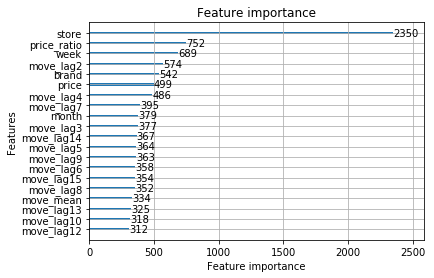

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

Sample MAPE is 18.055213592567252
Sample MAPE is 29.756204482295317
Sample MAPE is 18.2009194312406
Sample MAPE is 39.45138491667723
Sample MAPE is 63.831379631739146


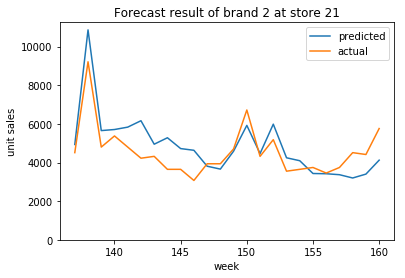

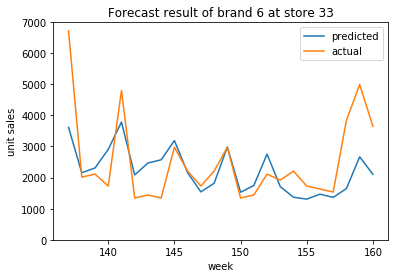

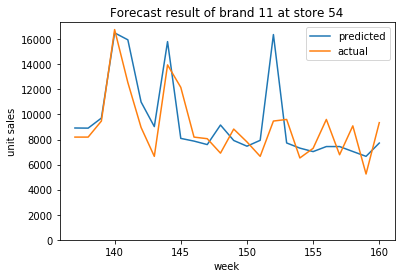

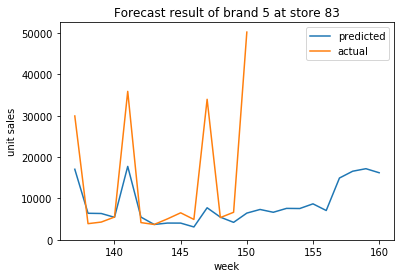

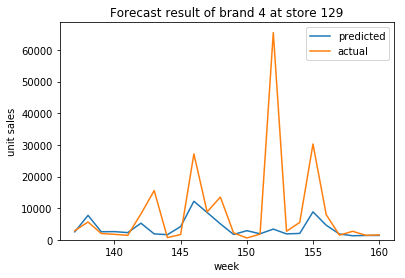

In [8]:
# Visualize forecast results
results = pd.concat(combined_all, axis=0)
random.seed(2)
for _ in range(5):
    store = random.choice(results['store'].unique())
    brand = random.choice(results['brand'].unique())
    plot_result(results, store, brand)